<h1 align="center">Department of Computer Science, Rutgers University</h1>
<h3 align="center">CS334 - Imaging and Multimedia</h3>
<h3 align="center">Assignment 4</h3>

## Importing the necessary libraries

In [1]:
import numpy as np
import pickle
from sklearn.metrics import confusion_matrix
from sklearn import svm
from scipy.spatial.distance import cdist
from skimage.morphology import disk, square, dilation, erosion, opening, closing
from skimage.filters import threshold_otsu, rank, gaussian
from skimage.measure import label, regionprops, moments, moments_central, moments_normalized, moments_hu, find_contours
from skimage import io, exposure
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

## Reading Images and Binarization

### Reading Images

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
ROOT = '/content/drive/MyDrive/OCR'
IMG_PATH = f'{ROOT}/images'

In [4]:
training = ['a', 'd', 'm', 'n', 'o', 'p', 'q', 'r', 'u', 'w']
training_reverse = {c: i for i, c in enumerate(training)}
testing = ['test']
train_set, test_set = [], []

for train in training:
    train_set.append(io.imread(f'{IMG_PATH}/{train}.bmp'))
for test in testing:
    test_set.append(io.imread(f'{IMG_PATH}/{test}.bmp'))

### Quick analysis of a training image

Size of an image:

In [5]:
print(train_set[0].shape)

(750, 600)


Visualizing the image 'a.bmp':

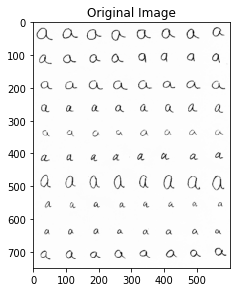

In [6]:
io.imshow(train_set[0])
plt.title('Original Image')
io.show()

Histogram of the above image:

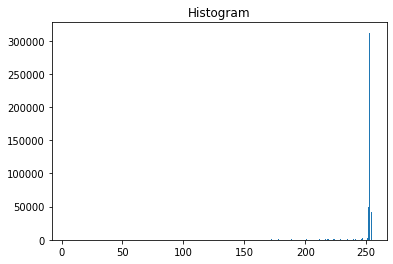

In [7]:
hist = exposure.histogram(train_set[0])
plt.bar(hist[1], hist[0])
plt.title('Histogram')
plt.show()

### Binarization and Thresholding

Since the image intensities are concentrated at a large value (~250), let's try threshold values 200, 210, 220, 230, 240, and 250.

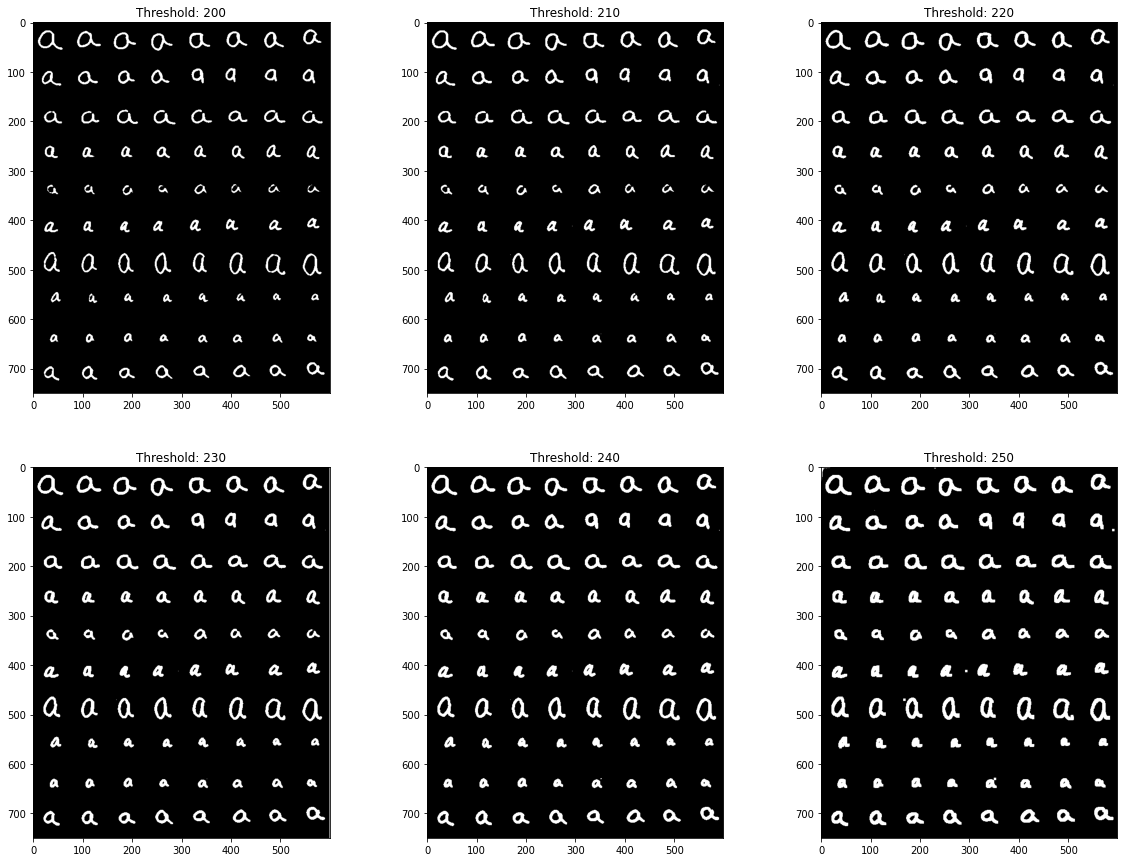

In [8]:
thresh = [200, 210, 220, 230, 240, 250]
fig, ax = plt.subplots(2, 3, figsize=(20, 15))
for i in range(2):
    for j in range(3):
        img_binary = (train_set[0] < thresh[3 * i + j]).astype(np.double)
        ax[i, j].imshow(img_binary, cmap='gray')
        ax[i, j].set_title(f'Threshold: {thresh[3 * i + j]}')

By comparison, the threshold values 220, 230 and 240 seem to separate the foreground handwritten text from the background quite well. Let's choose 235 as the threshold value for the binarization.

In [9]:
th = 235
train_imgs, test_imgs = [], []

for train_img in train_set:
    train_imgs.append((train_img < th).astype(np.double))
for test_img in test_set:
    test_imgs.append((test_img < th).astype(np.double))

Visualizing the binarized images:

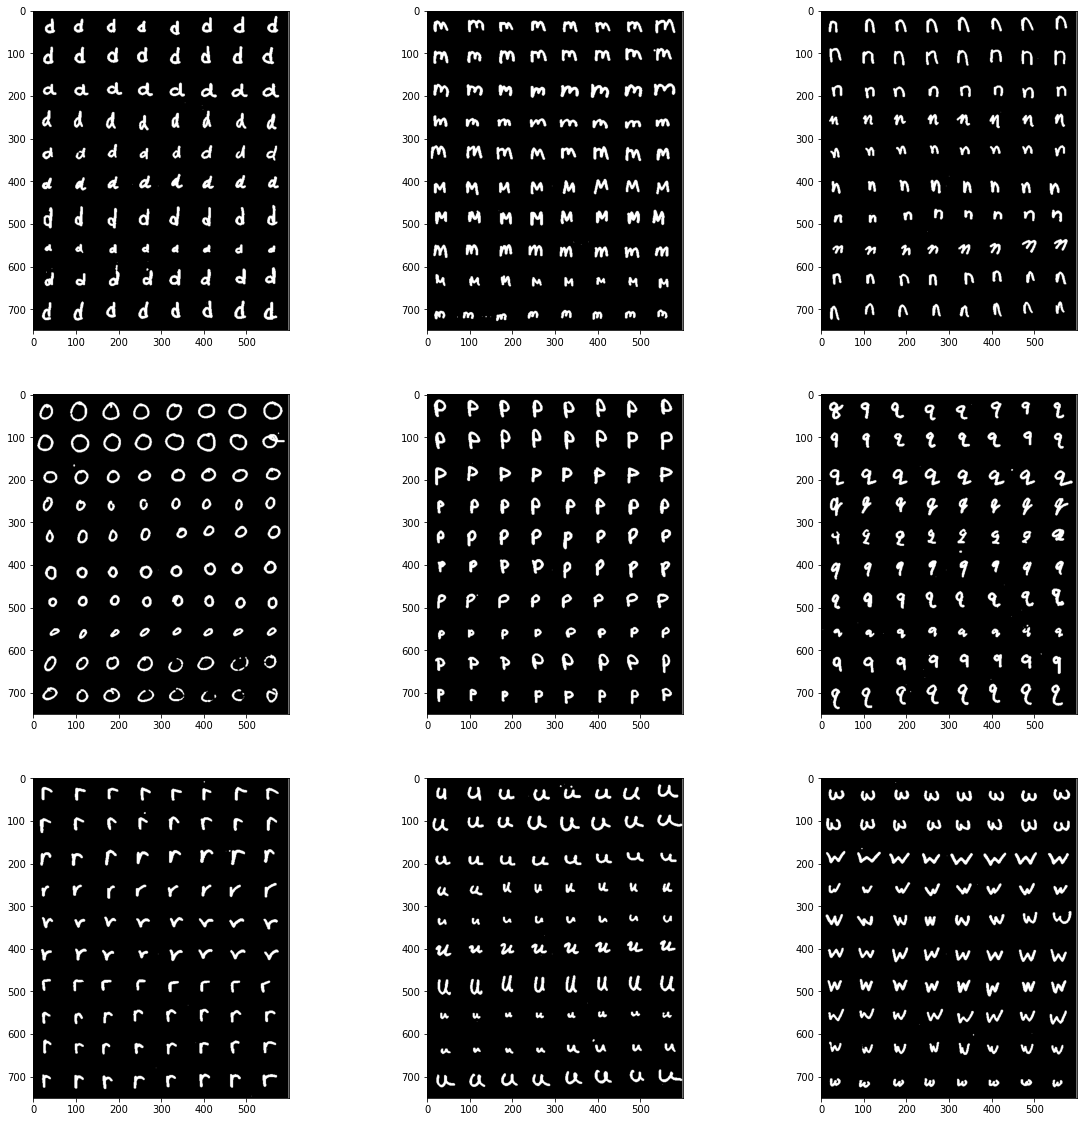

In [10]:
fig, ax = plt.subplots(3, 3, figsize=(20, 20))
ax = ax.ravel()

for img, axx in zip(train_imgs[1:], ax):
    axx.imshow(img, cmap='gray')

### Extracting Characters and Their Features

#### Connected Component Analysis

Testing the connected component analysis with the 'a.bmp' image:

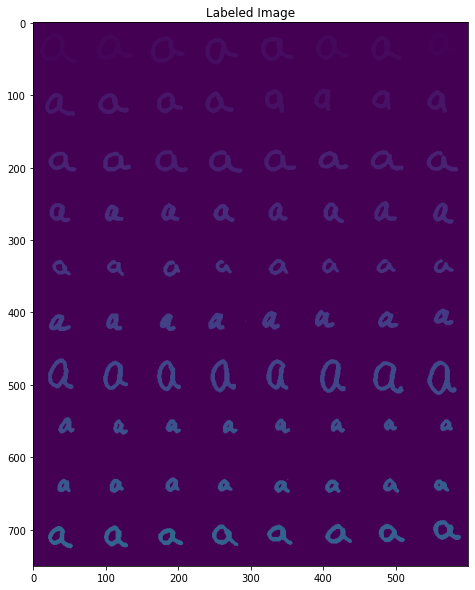

In [11]:
img_labels = label(train_imgs[0], background=0)
plt.figure(figsize=(10, 10))
plt.title('Labeled Image')
plt.imshow(img_labels, vmin=0, vmax=255)

Number of connected components:

In [12]:
print(np.argmax(img_labels))

418984


#### Displaying Component Bounding Boxes

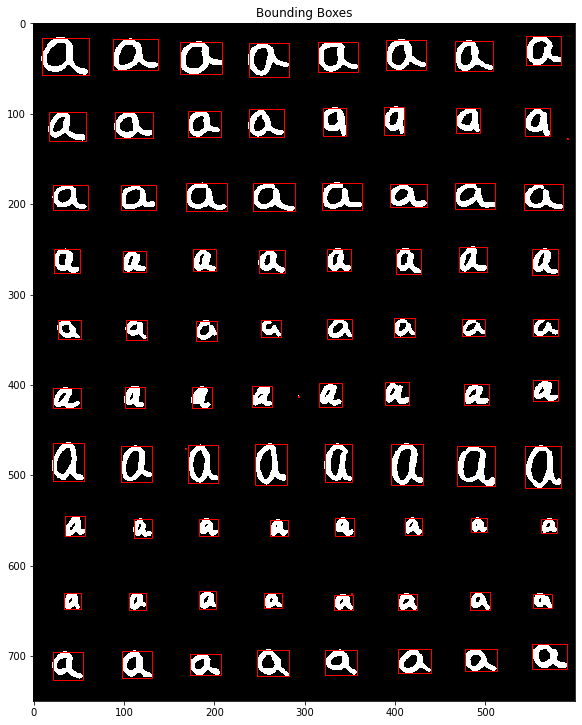

In [13]:
regions = regionprops(img_labels)
plt.figure(figsize=(10, 10))
io.imshow(train_imgs[0])
ax = plt.gca()
for props in regions:
    minr, minc, maxr, maxc = props.bbox
    ax.add_patch(Rectangle((minc, minr), maxc - minc, maxr - minr, fill=False, edgecolor='red', linewidth=1))
ax.set_title('Bounding Boxes')
io.show()

#### Computing Hu Moments and Removing Small Components

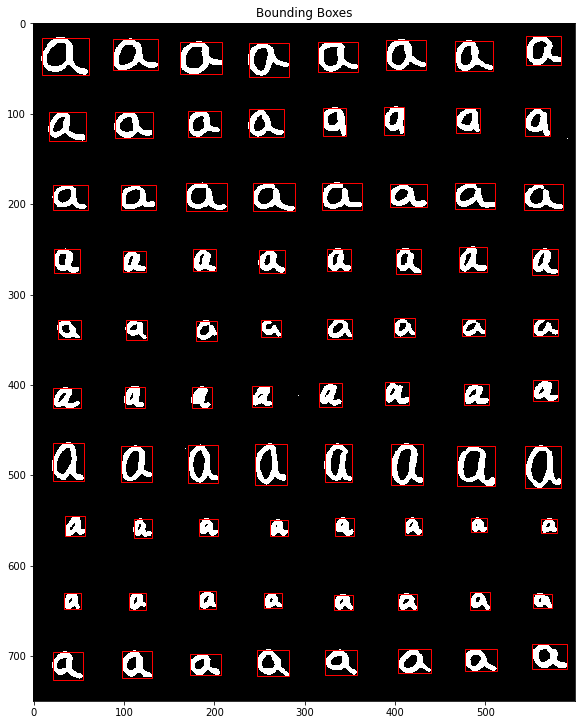

In [14]:
regions = regionprops(img_labels)
plt.figure(figsize=(10, 10))
io.imshow(train_imgs[0])
ax = plt.gca()
boxes = 0
for props in regions:
    minr, minc, maxr, maxc = props.bbox
    roi = train_imgs[0][minr:maxr, minc:maxc]
    # Omit regions that have small height or width
    if roi.shape[0] < 10 or roi.shape[1] < 10: continue
    # Omit regions that have large height or width
    if roi.shape[0] > 100 or roi.shape[1] > 100: continue
    # Omit regions that has small area
    if roi.size < 150: continue
    boxes += 1
    ax.add_patch(Rectangle((minc, minr), maxc - minc, maxr - minr, fill=False, edgecolor='red', linewidth=1))
ax.set_title('Bounding Boxes')
io.show()

Detected bounding boxes:

In [15]:
print(boxes)

80


### Storing Features

In [16]:
features = []
regions = regionprops(img_labels)
for props in regions:
    minr, minc, maxr, maxc = props.bbox
    roi = img_binary[minr:maxr, minc:maxc]
    # Omit regions that have small height or width
    if roi.shape[0] < 10 or roi.shape[1] < 10: continue
    # Omit regions that have large height or width
    if roi.shape[0] > 100 or roi.shape[1] > 100: continue
    # Omit regions that has small area
    if roi.size < 150: continue
    m = moments(roi)
    cc = m[0, 1] / m[0, 0]
    cr = m[1, 0] / m[0, 0]
    mu = moments_central(roi, center=(cr, cc))
    nu = moments_normalized(mu)
    hu = moments_hu(nu)
    features.append(hu)
features = np.asarray(features)
print(features.shape)

(80, 7)


### Building Character Features Database for Recognition

#### Creating a File to Process Each Image

In [17]:
CHARS_PER_IMG = 80

def extract_character_features(img_path, out_features, thresh=235, chars_per_image=CHARS_PER_IMG, plot=False, retry=False):
    # Read the image
    img = io.imread(img_path)
    # Convert to binary image
    img_binary = (img < thresh).astype(np.double)
    # Extract the connected components
    img_labels = label(img_binary, background=0)
    regions = regionprops(img_labels)
    # Extract the features
    features = []
    bboxes = []
    for props in regions:
        minr, minc, maxr, maxc = props.bbox
        roi = img_binary[minr:maxr, minc:maxc]
        # Omit regions that have small height or width
        if roi.shape[0] < 10 or roi.shape[1] < 10: continue
        # Omit regions that have large height or width
        if roi.shape[0] > 100 or roi.shape[1] > 100: continue
        # Omit regions that has small area
        if roi.size < 150: continue
        # Omit regions that has small aspect ratio
        if retry and roi.shape[1] / roi.shape[0] < 0.5: continue
        bboxes.append((minr, minc, maxr, maxc))
        m = moments(roi)
        cc = m[0, 1] / m[0, 0]
        cr = m[1, 0] / m[0, 0]
        mu = moments_central(roi, center=(cr, cc))
        nu = moments_normalized(mu)
        hu = moments_hu(nu)
        features.append(hu)
    if retry: return features, bboxes, img_labels
    if len(features) > chars_per_image:
        features, bboxes, img_labels = extract_character_features(img_path, out_features, thresh=250, chars_per_image=chars_per_image, plot=plot, retry=True)
    features = np.asarray(features)
    out_features.append(features)
    if plot:
        print(f"Number of detected characters: {features.shape[0]}")
        plt.figure(figsize=(10, 10))
        io.imshow(img_binary)
        ax = plt.gca()
        for (minr, minc, maxr, maxc) in bboxes:
            ax.add_patch(Rectangle((minc, minr), maxc - minc, maxr - minr, fill=False, edgecolor='red', linewidth=1))
        ax.set_title('Bounding Boxes')
        io.show()
    return features, bboxes, img_labels

Testing the above function:

Number of detected characters: 80


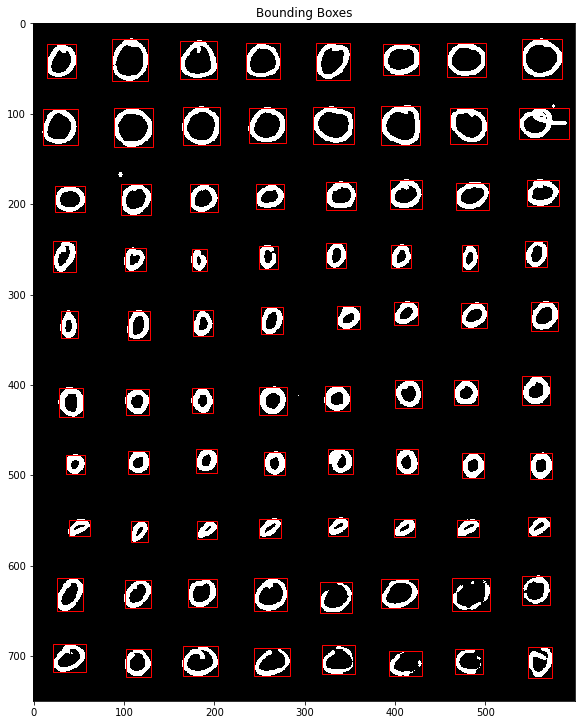

In [18]:
_, _, _ = extract_character_features(f'{IMG_PATH}/{training[4]}.bmp', [], plot=True)

In [19]:
feature_list = []
for img in training:
    extract_character_features(f'{IMG_PATH}/{img}.bmp', feature_list)
feature_list = np.asarray(feature_list).reshape(-1, 7)
print(feature_list.shape)

(800, 7)


#### Normalization

In [20]:
# Normalize the features by subtracting the mean and dividing by the standard deviation on each feature
means, stds = np.mean(feature_list, axis=0), np.std(feature_list, axis=0)
feature_list = (feature_list - means) / stds

#### Recognition on Training Data

In [21]:
D = cdist(feature_list, feature_list)
print(D.shape)

(800, 800)


Visualizing the pairwise distances:

/usr/local/lib/python3.7/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


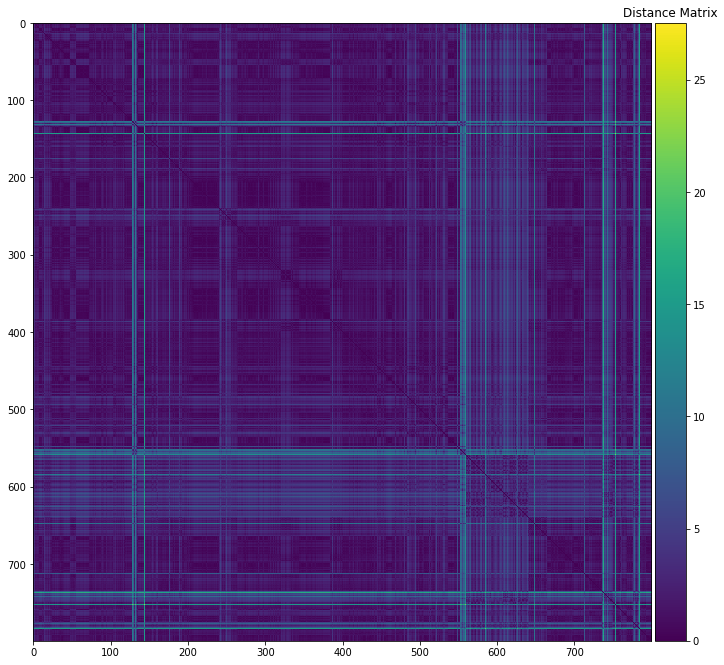

In [22]:
plt.figure(figsize=(10, 10))
io.imshow(D)
plt.title('Distance Matrix')
io.show()

In [23]:
D_index = np.argsort(D, axis=1)
print(D_index.shape)

(800, 800)


Recognized characters:

In [24]:
Ytrue = np.asarray([training[i] for i in range(len(training)) for j in range(CHARS_PER_IMG)])
pred = [Ytrue[i] for i in D_index[:, 1]]
class_recognition_rate = []
for i in range(len(training)):
    p = pred[i * CHARS_PER_IMG:(i + 1) * CHARS_PER_IMG]
    rate = np.mean(p == np.asarray(training[i]))
    class_recognition_rate.append(rate)
    print(f"Image {training[i]}: {p}, Class Recognition Rate: {rate}")

Image a: ['u', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'r', 'a', 'a', 'a', 'a', 'a', 'd', 'a', 'a', 'a', 'a', 'n', 'm', 'p', 'a', 'a', 'p', 'a', 'a', 'p', 'd', 'a', 'p', 'm', 'p', 'o', 'a', 'q', 'a', 'm', 'a', 'a', 'a', 'a', 'a', 'a', 'u', 'a', 'u', 'u', 'a', 'a', 'a', 'd', 'd', 'a', 'd', 'a', 'q', 'a', 'a', 'a', 'a', 'a', 'p', 'p', 'd', 'a', 'u', 'a', 'd', 'p', 'p', 'a', 'a', 'a'], Class Recognition Rate: 0.6375
Image d: ['d', 'p', 'd', 'd', 'p', 'q', 'd', 'p', 'p', 'd', 'd', 'd', 'a', 'w', 'd', 'p', 'd', 'd', 'd', 'd', 'd', 'd', 'p', 'a', 'd', 'd', 'q', 'd', 'q', 'd', 'd', 'd', 'd', 'p', 'd', 'p', 'r', 'p', 'p', 'd', 'r', 'd', 'd', 'd', 'd', 'd', 'd', 'q', 'd', 'q', 'd', 'p', 'd', 'q', 'd', 'p', 'a', 'a', 'd', 'd', 'a', 'p', 'a', 'o', 'd', 'd', 'p', 'q', 'd', 'd', 'p', 'p', 'd', 'd', 'd', 'd', 'p', 'q', 'd', 'd'], Class Recognition Rate: 0.5625
Image m: ['w', 'w', 'u', 'n', 'm', 'm', 'd', 'm', 'm', 'm', 'm', 'm', 'm', 'w', 'm', 'w', 'm', 'm', 'm', 'w', 'm', '

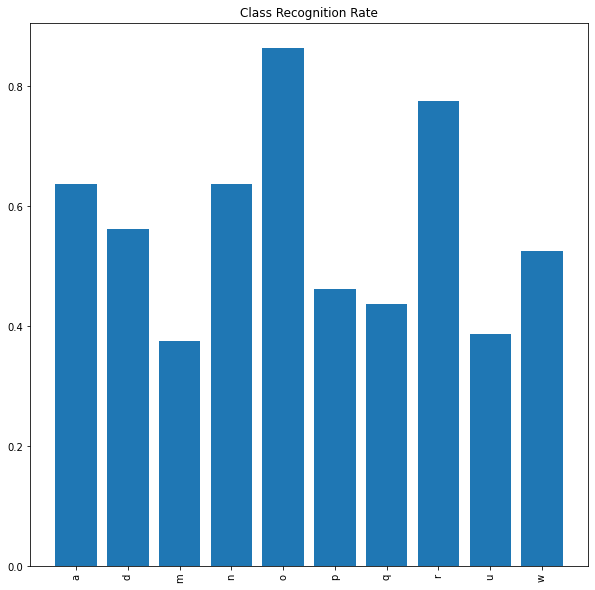

In [25]:
plt.figure(figsize=(10, 10))
plt.bar(range(len(training)), class_recognition_rate)
plt.xticks(range(len(training)), training, rotation=90)
plt.title('Class Recognition Rate')
plt.show()

#### Confusion Matrix

/usr/local/lib/python3.7/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


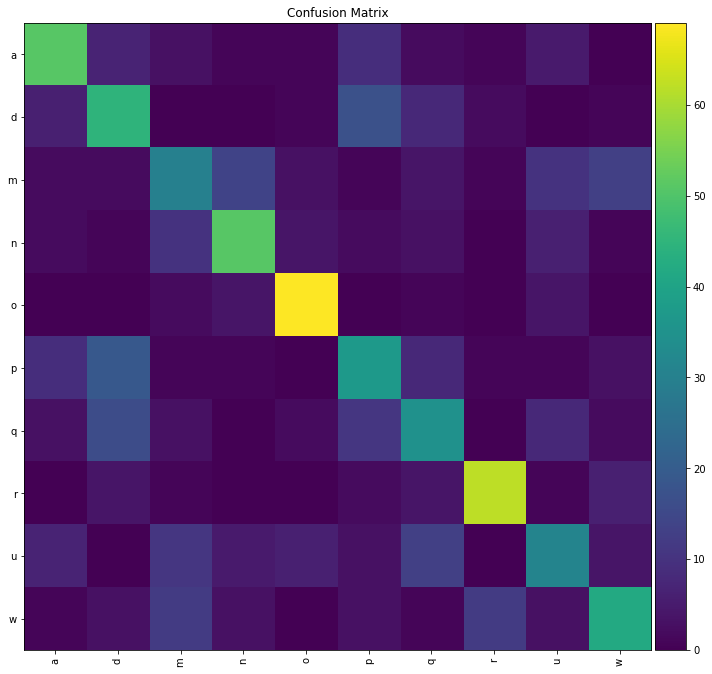

In [26]:
confM = confusion_matrix(Ytrue, Ytrue[D_index[:, 1]])
plt.figure(figsize=(10, 10))
plt.title('Confusion Matrix')
plt.xticks(np.arange(0, len(training), 1), training, rotation=90)
plt.yticks(np.arange(0, len(training), 1), training)
io.imshow(confM)
io.show()

### Testing (Recognition on Test Data)

#### Extracting Features from Test Images

Number of detected characters: 70


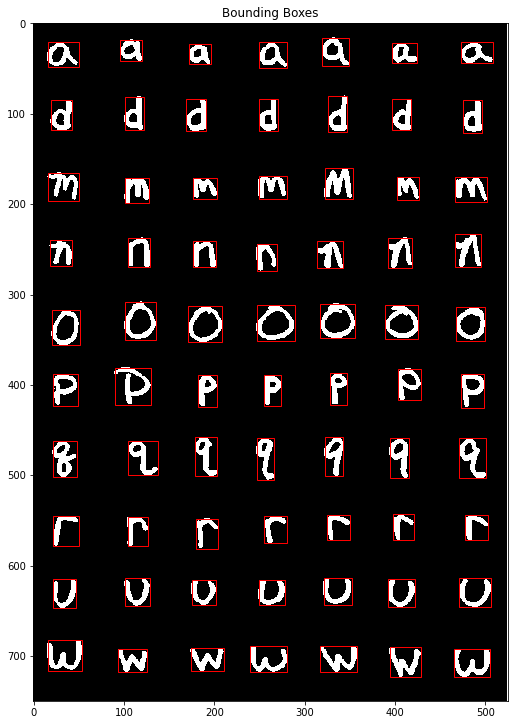

(70, 7)


In [27]:
features, bboxes, img_labels = extract_character_features(f'{IMG_PATH}/{testing[0]}.bmp', [], plot=True)
features = np.asarray(features).reshape(-1, 7)
print(features.shape)

#### Normalization

In [28]:
features = (features - means) / stds

#### Recognition

In [29]:
D = cdist(features, feature_list)
D_index = np.argsort(D, axis=1)[:, 0]
# Print the predicted labels
print([Ytrue[i] for i in D_index])

['a', 'a', 'a', 'n', 'a', 'd', 'p', 'q', 'd', 'a', 'd', 'd', 'p', 'd', 'n', 'm', 'm', 'q', 'm', 'n', 'm', 'n', 'n', 'n', 'n', 'n', 'm', 'n', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'a', 'a', 'q', 'a', 'a', 'p', 'p', 'q', 'd', 'q', 'q', 'q', 'q', 'u', 'r', 'r', 'w', 'r', 'w', 'w', 'w', 'n', 'r', 'r', 'n', 'n', 'n', 'n', 'w', 'w', 'r', 'w', 'w', 'm', 'w']


#### Generating recognition rate

In [30]:
pkl_file = open(f'{ROOT}/test_gt_py3.pkl', 'rb')
mydict = pickle.load(pkl_file)
pkl_file.close()
classes = mydict[b'classes']
locations = mydict[b'locations']

In [31]:
print(classes[:14])
print(locations[:14])

['a' 'a' 'a' 'a' 'a' 'a' 'a' 'd' 'd' 'd' 'd' 'd' 'd' 'd']
[[ 30  32]
 [108  30]
 [187  34]
 [262  36]
 [333  34]
 [485  32]
 [408  31]
 [ 26 108]
 [111 107]
 [185 107]
 [263 110]
 [338 111]
 [410 107]
 [486 110]]


In [32]:
def get_recognition_rate(pred, bboxes, classes, locations):
    correct = 0
    for i in range(len(pred)):
        for j in range(len(classes)):
            # Check whether the center is inside the bounding box
            if pred[i] == classes[j] and locations[j][0] >= bboxes[i][1] and locations[j][0] <= bboxes[i][3] and locations[j][1] >= bboxes[i][0] and locations[j][1] <= bboxes[i][2]:
                if pred[i] == classes[j]:
                    correct += 1
                break
    return correct / len(classes)

In [33]:
D = cdist(features, feature_list)
D_index = np.argsort(D, axis=1)[:, 0]
pred = np.asarray([Ytrue[i] for i in D_index])
rate = get_recognition_rate(pred, bboxes, classes, locations)
print(f"Recognition rate: {rate}")
for i in range(10):
    p = pred[7 * i:7 * (i + 1)]
    print(f"Predicted: {p}, Accuracy: {p[p == np.asarray(training[i])].shape[0] / 7 * 100:.2f}%")

Recognition rate: 0.5714285714285714
Predicted: ['a' 'a' 'a' 'n' 'a' 'd' 'p'], Accuracy: 57.14%
Predicted: ['q' 'd' 'a' 'd' 'd' 'p' 'd'], Accuracy: 57.14%
Predicted: ['n' 'm' 'm' 'q' 'm' 'n' 'm'], Accuracy: 57.14%
Predicted: ['n' 'n' 'n' 'n' 'n' 'm' 'n'], Accuracy: 85.71%
Predicted: ['o' 'o' 'o' 'o' 'o' 'o' 'o'], Accuracy: 100.00%
Predicted: ['a' 'a' 'q' 'a' 'a' 'p' 'p'], Accuracy: 28.57%
Predicted: ['q' 'd' 'q' 'q' 'q' 'q' 'u'], Accuracy: 71.43%
Predicted: ['r' 'r' 'w' 'r' 'w' 'w' 'w'], Accuracy: 42.86%
Predicted: ['n' 'r' 'r' 'n' 'n' 'n' 'n'], Accuracy: 0.00%
Predicted: ['w' 'w' 'r' 'w' 'w' 'm' 'w'], Accuracy: 71.43%


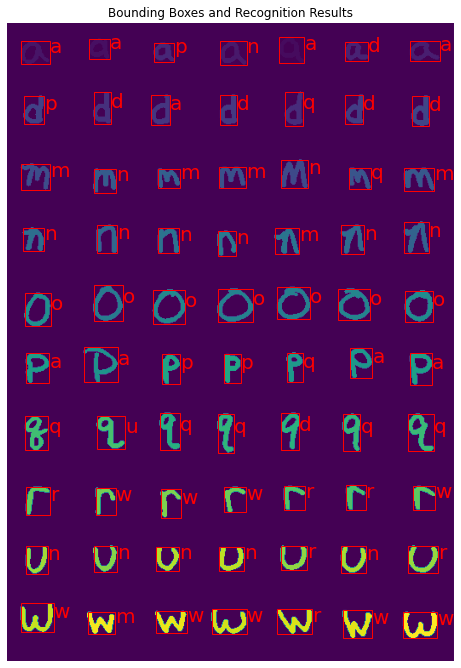

In [34]:
_, _, img_labels = extract_character_features(f'{IMG_PATH}/{testing[0]}.bmp', [])
plt.figure(figsize=(10, 15))
ax = plt.gca()
for i, (minr, minc, maxr, maxc) in enumerate(bboxes):
    ax.add_patch(Rectangle((minc, minr), maxc - minc, maxr - minr, fill=False, edgecolor='red', linewidth=1))
    ax.text(maxc, (minr + maxr) / 2, pred[i], color='red', fontsize=20)
plt.imshow(img_labels)
cb = plt.colorbar()
cb.remove()
ax.set_title('Bounding Boxes and Recognition Results')
ax.set_axis_off()
io.show()

### Enhancements

Let's revisit the class recognition rates for the training data. The rates were as following when sorted in descending order:

| Class | Recognition Rate |
|:-----:|:----------------:|
|  'o'  |       0.8625     |
|  'r'  |       0.775      |
|  'n'  |       0.6375     |
|  'a'  |       0.6375     |
|  'd'  |       0.5625     |
|  'w'  |       0.525      |
|  'p'  |       0.4625     |
|  'q'  |       0.4375     |
|  'u'  |       0.3785     |
|  'm'  |       0.375      |

This is also visible in the diagonal of the confusion matrix. Therefore, let's first look at the thresholding process to check whether it has any effect on the recognition rates.

Image a:
Number of detected characters: 80


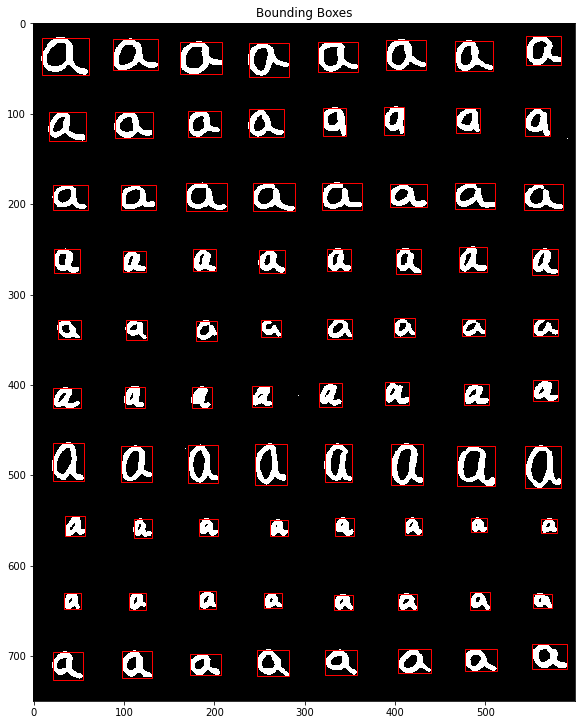

Image d:
Number of detected characters: 80


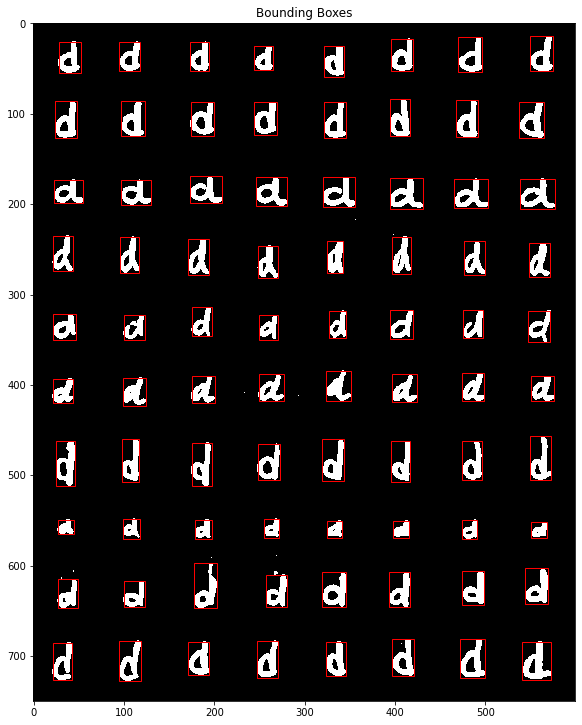

Image m:
Number of detected characters: 80


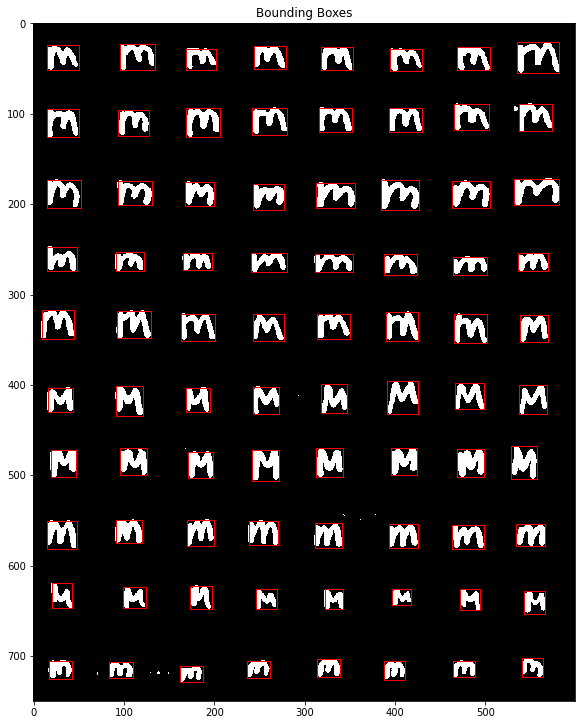

Image n:
Number of detected characters: 80


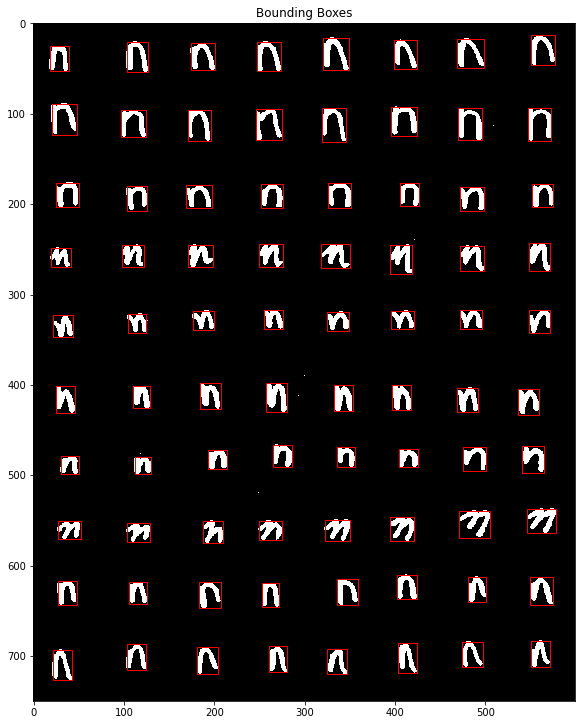

Image o:
Number of detected characters: 80


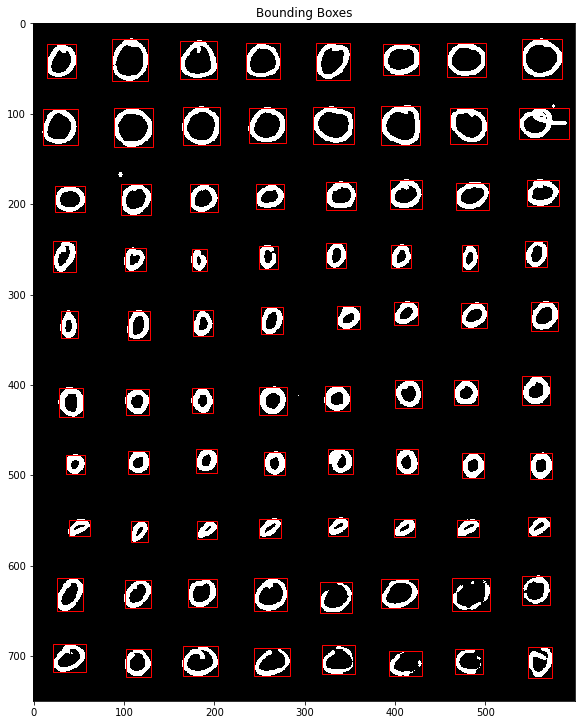

Image p:
Number of detected characters: 80


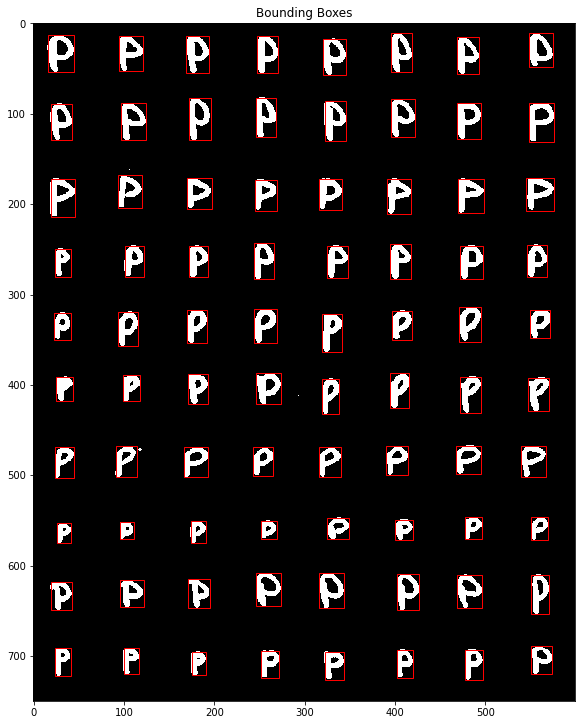

Image q:
Number of detected characters: 80


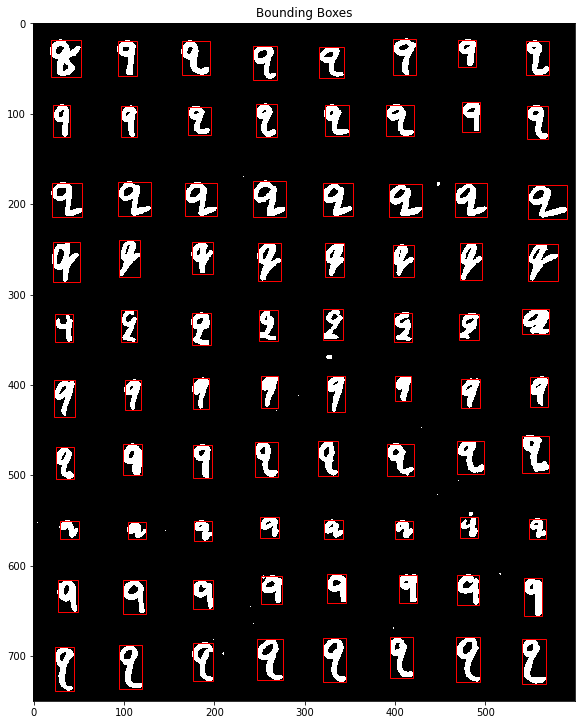

Image r:
Number of detected characters: 80


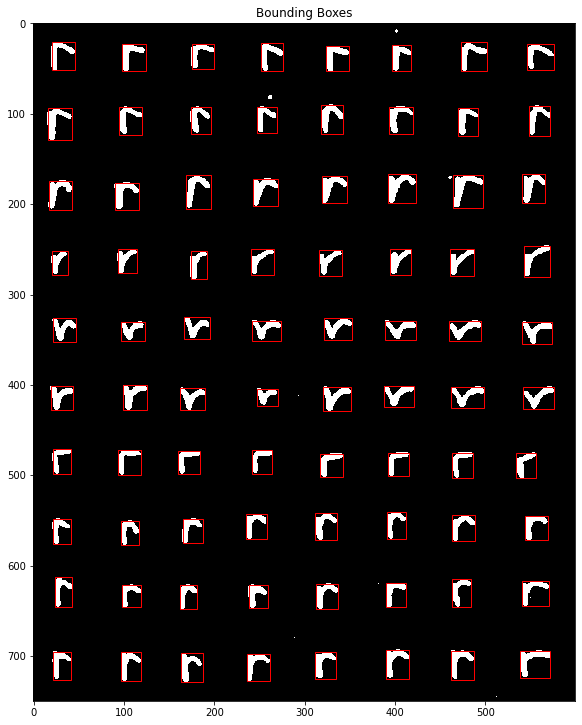

Image u:
Number of detected characters: 80


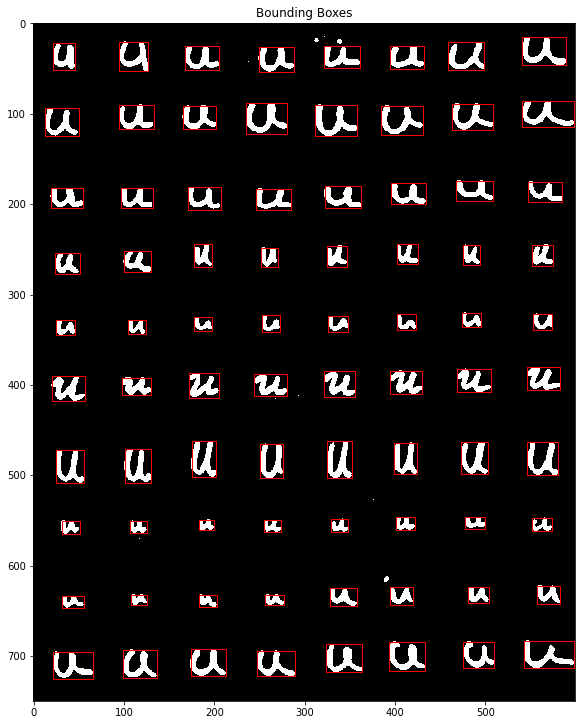

Image w:
Number of detected characters: 80


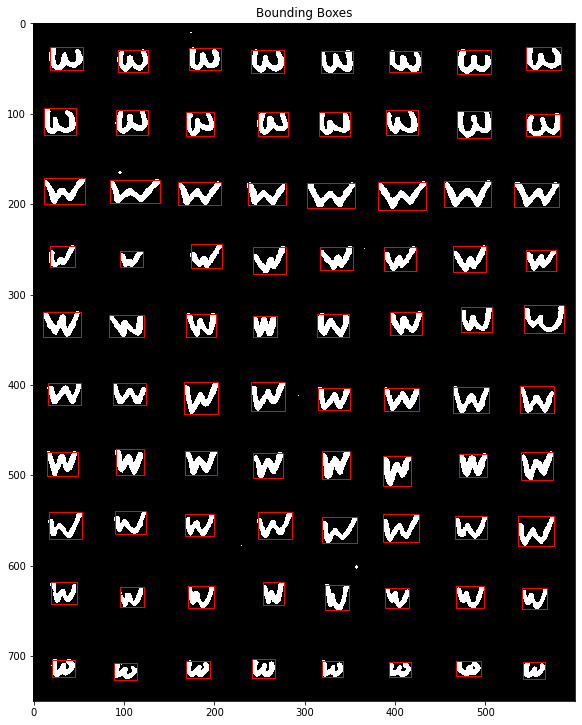

In [35]:
for img in training:
    print(f"Image {img}:")
    _, _, _ = extract_character_features(f'{IMG_PATH}/{img}.bmp', [], plot=True)

#### Enhancing Thresholding

One thing to note is that even though there's little to no background noise in all the images, the foreground characters are too sharp, and the sharpness has sometimes caused several character features to be destroyed. Therefore, let's try to automate the threshold selection process by using the Otsu's method.

In [36]:
def extract_character_features_v2(img_path, out_features, plot=False):
    # Read the image
    img = io.imread(img_path)
    # Denoise the image using the Gaussian filter
    img = gaussian(img, sigma=1)
    th = threshold_otsu(img) + 30 / 255
    img_binary = img <= th
    # Fill the holes in the characters using morphological closing
    img_binary = closing(img_binary, disk(1))
    # Extract the connected components
    img_labels = label(img_binary, background=0)
    regions = regionprops(img_labels)
    # Extract the features
    features = []
    bboxes = []
    for props in regions:
        minr, minc, maxr, maxc = props.bbox
        roi = img_binary[minr:maxr, minc:maxc]
        # Omit regions that have small height or width
        if roi.shape[0] < 10 or roi.shape[1] < 10: continue
        # Omit regions that have large height or width
        if roi.shape[0] > 100 or roi.shape[1] > 100: continue
        # Omit regions that has small area
        if roi.size < 150: continue
        bboxes.append((minr, minc, maxr, maxc))
        m = moments(roi)
        cc = m[0, 1] / m[0, 0]
        cr = m[1, 0] / m[0, 0]
        mu = moments_central(roi, center=(cr, cc))
        nu = moments_normalized(mu)
        hu = moments_hu(nu)
        features.append(hu)
    features = np.asarray(features)
    out_features.append(features)
    if plot:
        print(f"Number of detected characters: {features.shape[0]}")
        plt.figure(figsize=(10, 10))
        plt.imshow(img_binary)
        ax = plt.gca()
        for (minr, minc, maxr, maxc) in bboxes:
            ax.add_patch(Rectangle((minc, minr), maxc - minc, maxr - minr, fill=False, edgecolor='red', linewidth=1))
        ax.set_title('Bounding Boxes')
        plt.show()
    return features, bboxes, img_labels

Let's modify the original character extraction function to use a different fixed threshold value and perform a morphological operation after the binarization.

In [37]:
CHARS_PER_IMG = 80

def extract_character_features_v3(img_path, out_features, thresh=235, chars_per_image=CHARS_PER_IMG, plot=False, retry=False):
    # Read the image
    img = io.imread(img_path)
    # Convert to binary image
    img_binary = (img < thresh).astype(np.double)
    img_binary = erosion(img_binary, disk(1))
    # Extract the connected components
    img_labels = label(img_binary, background=0)
    regions = regionprops(img_labels)
    # Extract the features
    features = []
    bboxes = []
    for props in regions:
        minr, minc, maxr, maxc = props.bbox
        roi = img_binary[minr:maxr, minc:maxc]
        # Omit regions that have small height or width
        if roi.shape[0] < 10 or roi.shape[1] < 10: continue
        # Omit regions that have large height or width
        if roi.shape[0] > 100 or roi.shape[1] > 100: continue
        # Omit regions that has small area
        if roi.size < 150: continue
        # Omit regions that has small aspect ratio
        if retry and roi.shape[1] / roi.shape[0] < 0.5: continue
        bboxes.append((minr, minc, maxr, maxc))
        m = moments(roi)
        cc = m[0, 1] / m[0, 0]
        cr = m[1, 0] / m[0, 0]
        mu = moments_central(roi, center=(cr, cc))
        nu = moments_normalized(mu)
        hu = moments_hu(nu)
        features.append(hu)
    if retry: return features, bboxes, img_labels
    if len(features) != chars_per_image:
        features, bboxes, img_labels = extract_character_features_v3(img_path, out_features, thresh=250, chars_per_image=chars_per_image, plot=plot, retry=True)
    features = np.asarray(features)
    out_features.append(features)
    if plot:
        print(f"Number of detected characters: {features.shape[0]}")
        plt.figure(figsize=(10, 10))
        plt.imshow(img_binary)
        ax = plt.gca()
        for (minr, minc, maxr, maxc) in bboxes:
            ax.add_patch(Rectangle((minc, minr), maxc - minc, maxr - minr, fill=False, edgecolor='red', linewidth=1))
        ax.set_title('Bounding Boxes')
        plt.show()
    return features, bboxes, img_labels

Testing the two enhanced character extraction processs:

Image a:
Number of detected characters: 80


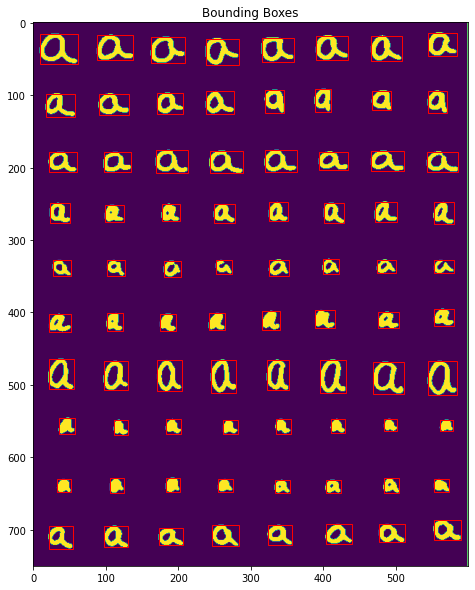

Image d:
Number of detected characters: 80


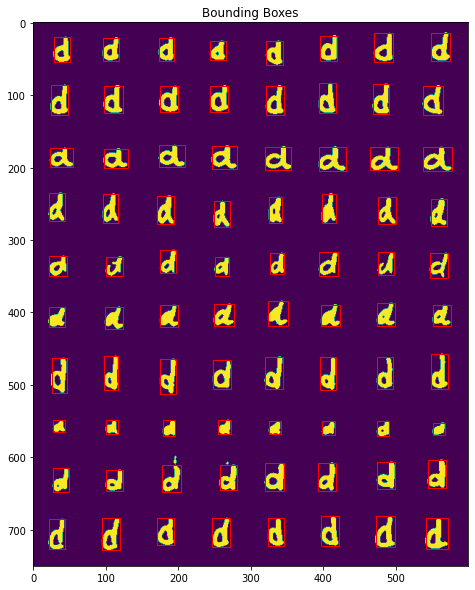

Image m:
Number of detected characters: 80


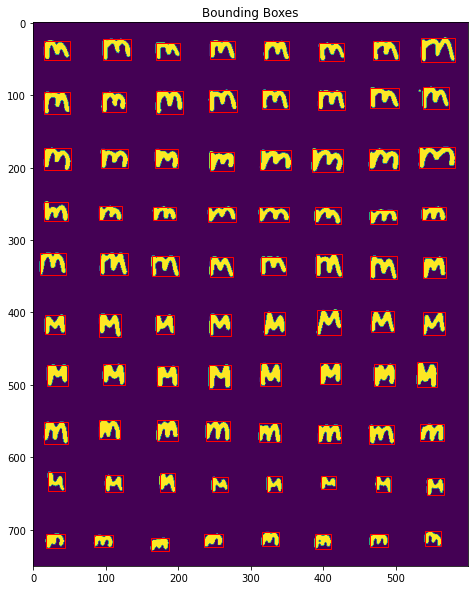

In [38]:
for img in training[:3]:
    print(f"Image {img}:")
    _, _, _ = extract_character_features_v2(f'{IMG_PATH}/{img}.bmp', [], plot=True)

Image a:
Number of detected characters: 80


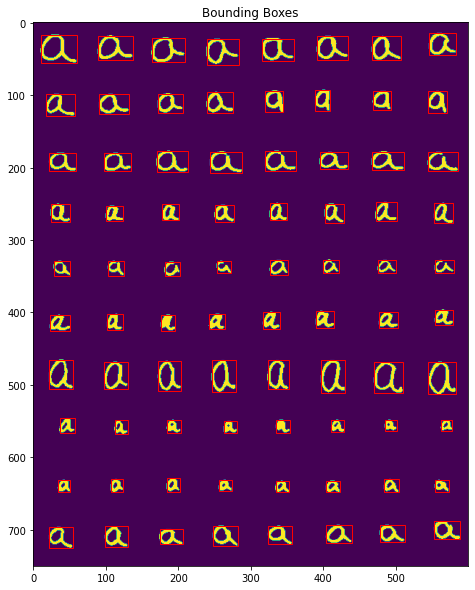

Image d:
Number of detected characters: 80


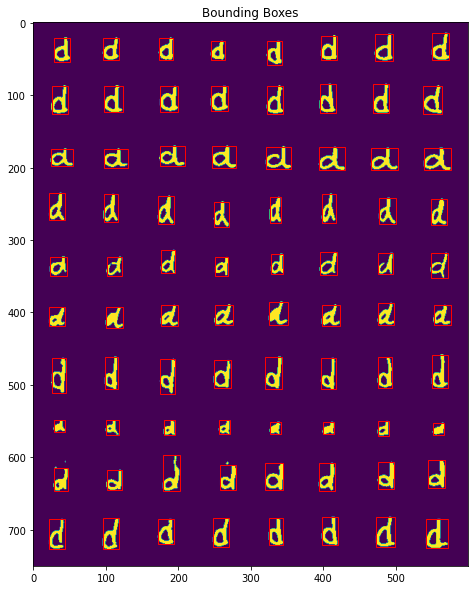

Image m:
Number of detected characters: 80


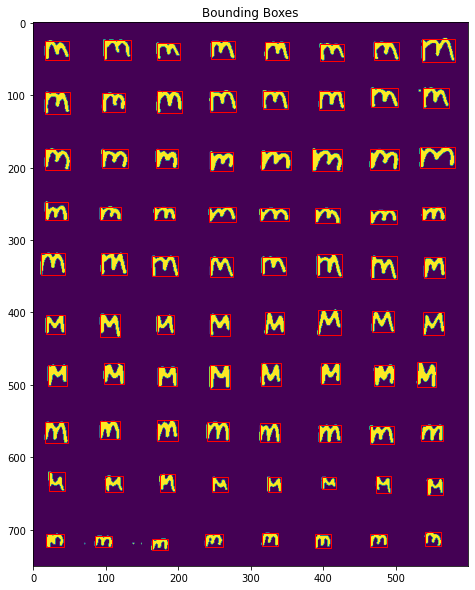

In [39]:
for img in training[:3]:
    print(f"Image {img}:")
    _, _, _ = extract_character_features_v3(f'{IMG_PATH}/{img}.bmp', [], thresh=240, plot=True)

Now let's retrain the classifier with the v2 character extraction function and see if the recognition rates have improved.

/usr/local/lib/python3.7/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


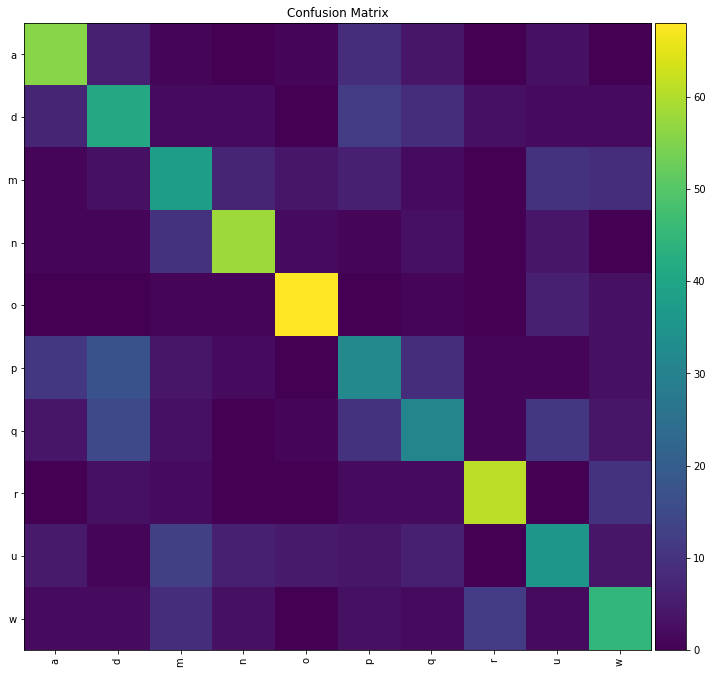

In [40]:
feature_list = []
for img in training:
    _, _, _ = extract_character_features_v2(f'{IMG_PATH}/{img}.bmp', feature_list)
feature_list = np.asarray(feature_list).reshape(-1, 7)
means, stds = np.mean(feature_list, axis=0), np.std(feature_list, axis=0)
feature_list = (feature_list - means) / stds
D = cdist(feature_list, feature_list)
D_index = np.argsort(D, axis=1)[:, 1]
Ytrue = np.asarray([training[i] for i in range(len(training)) for j in range(CHARS_PER_IMG)])
confM = confusion_matrix(Ytrue, Ytrue[D_index])
plt.figure(figsize=(10, 10))
plt.title('Confusion Matrix')
plt.xticks(np.arange(0, len(training), 1), training, rotation=90)
plt.yticks(np.arange(0, len(training), 1), training)
io.imshow(confM)
io.show()

To confirm if the recognition rates have been improved, let's look at the class recognition rates for the training data.

In [41]:
predv2 = [Ytrue[i] for i in D_index]
class_recognition_ratev2 = []
for i in range(len(training)):
    p = predv2[i * CHARS_PER_IMG:(i + 1) * CHARS_PER_IMG]
    rate = np.mean(p == np.asarray(training[i]))
    class_recognition_ratev2.append(rate)
# Calculate the overall improvement in recognition rate
improvement = 0
for i in range(len(training)):
    improvement += (class_recognition_ratev2[i] - class_recognition_rate[i]) / class_recognition_rate[i]
improvement /= len(training)
print(f"Overall improvement in recognition rate: {improvement * 100:.2f}%")

Overall improvement in recognition rate: 3.66%


Now let's retrain the classifier with the v3 character extraction function and see if the recognition rates have improved.

/usr/local/lib/python3.7/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


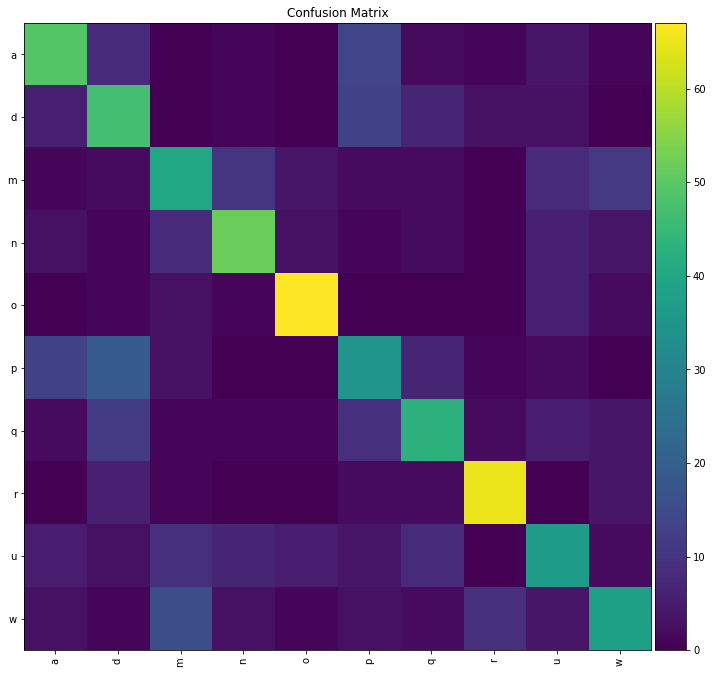

In [42]:
feature_list = []
for img in training:
    _, _, _ = extract_character_features_v3(f'{IMG_PATH}/{img}.bmp', feature_list, thresh=240)
feature_list = np.asarray(feature_list).reshape(-1, 7)
means, stds = np.mean(feature_list, axis=0), np.std(feature_list, axis=0)
feature_list = (feature_list - means) / stds
D = cdist(feature_list, feature_list)
D_index = np.argsort(D, axis=1)[:, 1]
Ytrue = np.asarray([training[i] for i in range(len(training)) for j in range(CHARS_PER_IMG)])
confM = confusion_matrix(Ytrue, Ytrue[D_index])
plt.figure(figsize=(10, 10))
plt.title('Confusion Matrix')
plt.xticks(np.arange(0, len(training), 1), training, rotation=90)
plt.yticks(np.arange(0, len(training), 1), training)
io.imshow(confM)
io.show()

In [43]:
predv3 = [Ytrue[i] for i in D_index]
class_recognition_ratev3 = []
for i in range(len(training)):
    p = predv3[i * CHARS_PER_IMG:(i + 1) * CHARS_PER_IMG]
    rate = np.mean(p == np.asarray(training[i]))
    class_recognition_ratev3.append(rate)
# Calculate the overall improvement in recognition rate
improvement = 0
for i in range(len(training)):
    improvement += (class_recognition_ratev3[i] - class_recognition_rate[i]) / class_recognition_rate[i]
improvement /= len(training)
print(f"Overall improvement in recognition rate: {improvement * 100:.2f}%")

Overall improvement in recognition rate: 6.50%


Using the fixed threshold value 240 and performing a morphological erosion operation after the binarization gave best results. Therefore, let's use the v3 character extraction function for the rest of the enhancements.

#### Enhancing Feature Extraction

Let's add contour features to the character features database.

In [44]:
CHARS_PER_IMG = 80

def extract_character_features_v4(img_path, out_features, thresh=235, min_aspect_ratio=0.5, chars_per_image=CHARS_PER_IMG, plot=False, retry=False):
    # Read the image
    img = io.imread(img_path)
    # Convert to binary image
    img_binary = (img < thresh).astype(np.double)
    img_binary = erosion(img_binary, disk(1))
    # Extract the connected components
    img_labels = label(img_binary, background=0)
    regions = regionprops(img_labels)
    # Extract the features
    features = []
    bboxes = []
    for props in regions:
        minr, minc, maxr, maxc = props.bbox
        roi = img_binary[minr:maxr, minc:maxc]
        # Omit regions that have small height or width
        if roi.shape[0] < 10 or roi.shape[1] < 10: continue
        # Omit regions that have large height or width
        if roi.shape[0] > 100 or roi.shape[1] > 100: continue
        # Omit regions that has small area
        if roi.size < 150: continue
        # Omit regions that has small aspect ratio
        if retry and roi.shape[1] / roi.shape[0] < min_aspect_ratio: continue
        bboxes.append((minr, minc, maxr, maxc))
        m = moments(roi)
        cc = m[0, 1] / m[0, 0]
        cr = m[1, 0] / m[0, 0]
        mu = moments_central(roi, center=(cr, cc))
        nu = moments_normalized(mu)
        hu = moments_hu(nu)
        # Find contours of the region
        contours = find_contours(img_binary[minr:maxr, minc:maxc], 0.5)
        # Find the longest contour
        longest_contour = max(contours, key=len)
        # Find the centroid of the longest contour
        centroid = np.mean(longest_contour, axis=0)
        # Find the angle of the longest contour
        angle = np.arctan2(centroid[1] - cr, centroid[0] - cc)
        # Find the length of the longest contour
        length = len(longest_contour)
        # Find the number of holes in the region
        holes = len(find_contours(1 - roi, 0.5))
        hu = np.append(hu, [centroid[0], centroid[1], angle, length, holes])
        features.append(hu)
    if retry: return features, bboxes, img_labels
    if len(features) != chars_per_image:
        features, bboxes, img_labels = extract_character_features_v4(img_path, out_features, min_aspect_ratio=min_aspect_ratio, thresh=250, chars_per_image=chars_per_image, plot=plot, retry=True)
    features = np.asarray(features)
    out_features.append(features)
    if plot:
        print(f"Number of detected characters: {features.shape[0]}")
        plt.figure(figsize=(10, 10))
        plt.imshow(img_binary)
        ax = plt.gca()
        for (minr, minc, maxr, maxc) in bboxes:
            ax.add_patch(Rectangle((minc, minr), maxc - minc, maxr - minr, fill=False, edgecolor='red', linewidth=1))
        ax.set_title('Bounding Boxes')
        plt.show()
    return features, bboxes, img_labels

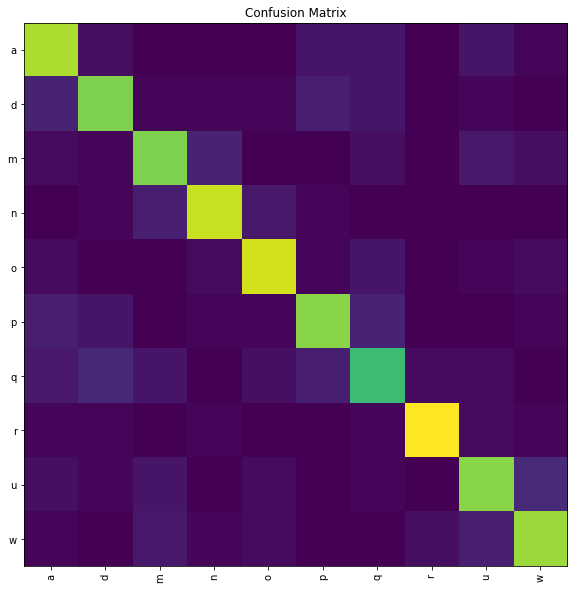

In [45]:
feature_list = []
for img in training:
    _, _, _ = extract_character_features_v4(f'{IMG_PATH}/{img}.bmp', feature_list, thresh=240)
feature_list = np.asarray(feature_list).reshape(-1, 12)
means, stds = np.mean(feature_list, axis=0), np.std(feature_list, axis=0)
feature_list = (feature_list - means) / stds
D = cdist(feature_list, feature_list)
D_index = np.argsort(D, axis=1)[:, 1]
Ytrue = np.asarray([training[i] for i in range(len(training)) for j in range(CHARS_PER_IMG)])
confM = confusion_matrix(Ytrue, Ytrue[D_index])
plt.figure(figsize=(10, 10))
plt.title('Confusion Matrix')
plt.xticks(np.arange(0, len(training), 1), training, rotation=90)
plt.yticks(np.arange(0, len(training), 1), training)
plt.imshow(confM)
plt.show()

In [46]:
predv4 = [Ytrue[i] for i in D_index]
class_recognition_ratev4 = []
for i in range(len(training)):
    p = predv4[i * CHARS_PER_IMG:(i + 1) * CHARS_PER_IMG]
    rate = np.mean(p == np.asarray(training[i]))
    class_recognition_ratev4.append(rate)
# Calculate the overall improvement in recognition rate
improvement = 0
for i in range(len(training)):
    improvement += (class_recognition_ratev4[i] - class_recognition_rate[i]) / class_recognition_rate[i]
improvement /= len(training)
print(f"Overall improvement in recognition rate: {improvement * 100:.2f}%")

Overall improvement in recognition rate: 44.71%


The introduction of contour features has improved the recognition rates for the training data significantly. The reason for this is that the contour features are more robust to the variations in the character shapes. Let's look at the class recognition rates for the training data.

In [47]:
for i in range(len(training)):
    print(f"Image {training[i]}: {p}, Class Recognition Rate: {class_recognition_ratev4[i] * 100:.2f}%")

Image a: ['w', 'w', 'w', 'w', 'w', 'w', 'w', 'w', 'u', 'w', 'w', 'w', 'w', 'm', 'w', 'w', 'w', 'w', 'w', 'w', 'w', 'w', 'w', 'w', 'w', 'r', 'w', 'w', 'w', 'w', 'w', 'r', 'r', 'w', 'w', 'w', 'w', 'm', 'w', 'o', 'w', 'u', 'w', 'm', 'w', 'w', 'w', 'w', 'u', 'm', 'm', 'w', 'w', 'w', 'w', 'u', 'w', 'w', 'w', 'w', 'w', 'o', 'w', 'w', 'w', 'u', 'n', 'w', 'w', 'w', 'w', 'w', 'w', 'a', 'w', 'w', 'u', 'w', 'w', 'w'], Class Recognition Rate: 80.00%
Image d: ['w', 'w', 'w', 'w', 'w', 'w', 'w', 'w', 'u', 'w', 'w', 'w', 'w', 'm', 'w', 'w', 'w', 'w', 'w', 'w', 'w', 'w', 'w', 'w', 'w', 'r', 'w', 'w', 'w', 'w', 'w', 'r', 'r', 'w', 'w', 'w', 'w', 'm', 'w', 'o', 'w', 'u', 'w', 'm', 'w', 'w', 'w', 'w', 'u', 'm', 'm', 'w', 'w', 'w', 'w', 'u', 'w', 'w', 'w', 'w', 'w', 'o', 'w', 'w', 'w', 'u', 'n', 'w', 'w', 'w', 'w', 'w', 'w', 'a', 'w', 'w', 'u', 'w', 'w', 'w'], Class Recognition Rate: 73.75%
Image m: ['w', 'w', 'w', 'w', 'w', 'w', 'w', 'w', 'u', 'w', 'w', 'w', 'w', 'm', 'w', 'w', 'w', 'w', 'w', 'w', 'w', '

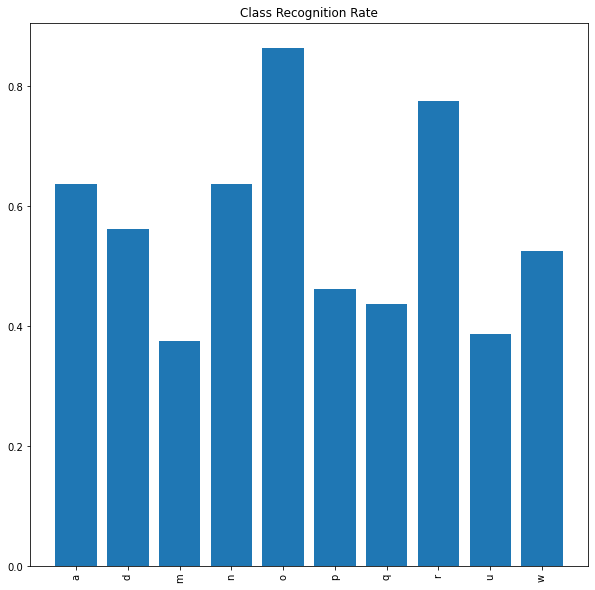

In [48]:
plt.figure(figsize=(10, 10))
plt.bar(range(len(training)), class_recognition_rate)
plt.xticks(range(len(training)), training, rotation=90)
plt.title('Class Recognition Rate')
plt.show()

#### Enhancing the Classifier

Let's use a Support Vector Machine (SVM) classifier instead of the KNN classifier.

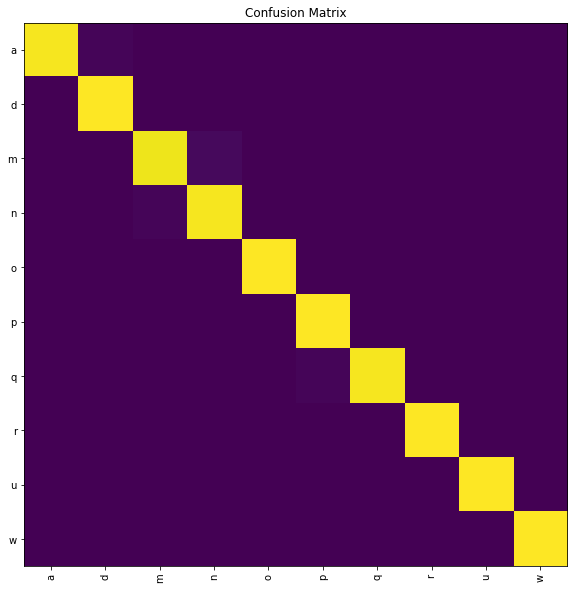

In [49]:
feature_list = []
for img in training:
    _, _, _ = extract_character_features_v4(f'{IMG_PATH}/{img}.bmp', feature_list, thresh=240)
feature_list = np.asarray(feature_list).reshape(-1, 12)
means, stds = np.mean(feature_list, axis=0), np.std(feature_list, axis=0)
feature_list = (feature_list - means) / stds
# Use a SVM classifier to classify the characters
clf = svm.SVC(kernel='rbf', gamma='scale', C=200)
clf.fit(feature_list, Ytrue)
predv5 = clf.predict(feature_list)
confM = confusion_matrix(Ytrue, predv5)
plt.figure(figsize=(10, 10))
plt.title('Confusion Matrix')
plt.xticks(np.arange(0, len(training), 1), training, rotation=90)
plt.yticks(np.arange(0, len(training), 1), training)
plt.imshow(confM)
plt.show()

In [50]:
class_recognition_ratev5 = []
for i in range(len(training)):
    p = predv5[i * CHARS_PER_IMG:(i + 1) * CHARS_PER_IMG]
    rate = np.mean(p == np.asarray(training[i]))
    class_recognition_ratev5.append(rate)
# Calculate the overall improvement in recognition rate
improvement = 0
for i in range(len(training)):
    improvement += (class_recognition_ratev5[i] - class_recognition_rate[i]) / class_recognition_rate[i]
improvement /= len(training)
print(f"Overall improvement in recognition rate: {improvement * 100:.2f}%")

Overall improvement in recognition rate: 88.30%


Changing the classifier to a SVM classifier gave a huge improvement in the recognition rates. Let's look at the class recognition rates for the training data.

In [51]:
for i in range(len(training)):
    print(f"Image {training[i]} Recognition Rate: {class_recognition_ratev4[i] * 100:.2f}%")

Image a Recognition Rate: 80.00%
Image d Recognition Rate: 73.75%
Image m Recognition Rate: 73.75%
Image n Recognition Rate: 83.75%
Image o Recognition Rate: 85.00%
Image p Recognition Rate: 75.00%
Image q Recognition Rate: 62.50%
Image r Recognition Rate: 91.25%
Image u Recognition Rate: 75.00%
Image w Recognition Rate: 77.50%


Let's use this feature database to test the SVM classifier on the test data.

In [52]:
features, bboxes, img_labels = extract_character_features_v4(f'{IMG_PATH}/{testing[0]}.bmp', [], min_aspect_ratio=0.4)
features = (features - means) / stds
feature_list = np.asarray([features]).reshape(-1, 12)
pred = clf.predict(features)
print(f"Recognition Rate: {get_recognition_rate(pred, bboxes, classes, locations)}")
for i in range(10):
    p = pred[7 * i:7 * (i + 1)]
    print(f"Predicted: {p}, Accuracy: {p[p == np.asarray(training[i])].shape[0] / 7 * 100:.2f}%")

Recognition Rate: 0.7285714285714285
Predicted: ['a' 'a' 'a' 'a' 'a' 'a' 'a'], Accuracy: 100.00%
Predicted: ['d' 'd' 'm' 'd' 'd' 'd' 'd'], Accuracy: 85.71%
Predicted: ['m' 'u' 'n' 'm' 'm' 'm' 'm'], Accuracy: 71.43%
Predicted: ['m' 'm' 'n' 'm' 'n' 'n' 'n'], Accuracy: 57.14%
Predicted: ['o' 'o' 'o' 'o' 'o' 'o' 'o'], Accuracy: 100.00%
Predicted: ['a' 'p' 'q' 'p' 'p' 'p' 'p'], Accuracy: 71.43%
Predicted: ['q' 'q' 'q' 'd' 'q' 'p' 'q'], Accuracy: 71.43%
Predicted: ['r' 'r' 'r' 'r' 'w' 'r' 'w'], Accuracy: 71.43%
Predicted: ['n' 'w' 'w' 'n' 'u' 'a' 'u'], Accuracy: 28.57%
Predicted: ['w' 'w' 'w' 'w' 'w' 'w' 'w'], Accuracy: 100.00%


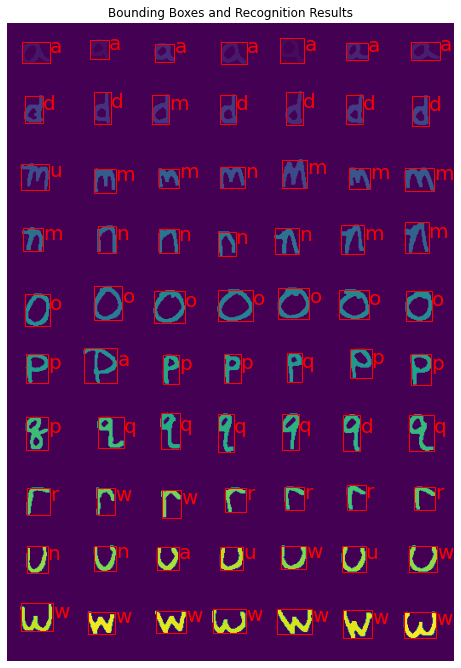

In [53]:
plt.figure(figsize=(10, 15))
ax = plt.gca()
for i, (minr, minc, maxr, maxc) in enumerate(bboxes):
    ax.add_patch(Rectangle((minc, minr), maxc - minc, maxr - minr, fill=False, edgecolor='red', linewidth=1))
    ax.text(maxc, (minr + maxr) / 2, pred[i], color='red', fontsize=20)
plt.imshow(img_labels)
cb = plt.colorbar()
cb.remove()
ax.set_title('Bounding Boxes and Recognition Results')
ax.set_axis_off()
plt.show()